# OpenVINO™ Explainable AI Toolkit (2/3): Deep Dive

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.10. Please make sure that your environment fulfill to this requirement before running it </div>

This is the **second notebook** in series of exploring [OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/):

1. [OpenVINO™ Explainable AI Toolkit (1/3): Basic](../explainable-ai-1-basic/README.md)
2. [**OpenVINO™ Explainable AI Toolkit (2/3): Deep Dive**](../explainable-ai-2-deep-dive/README.md)
3. [OpenVINO™ Explainable AI Toolkit (3/3): Saliency map interpretation](../explainable-ai-3-map-interpretation/README.md)

[OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/) provides a suite of XAI algorithms for visual explanation of
[OpenVINO™](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

Using **OpenVINO XAI**, you can generate **saliency maps** that highlight regions of interest in input images from the model's perspective. This helps users understand why complex AI models produce specific responses.

This notebook shows an example of how to use OpenVINO XAI, exploring its methods and functionality.

It displays a heatmap indicating areas of interest where a neural network (for classification or detection) focuses before making a decision.

Let's imagine the case that our OpenVINO IR model is up and running on a inference pipeline. While watching the outputs, we may want to analyze the model's behavior for debugging or understanding purposes.

By using the OpenVINO XAI `Explainer`, we can visualize why the model gives such responses, meaning on which areas it focused before predicting a particular label.

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/explainable-ai-2-deep-dive/explainable-ai-2-deep-dive.ipynb" />


#### Table of contents:

- [Prerequisites](#Prerequisites)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
    - [Download IR model](#Download-IR-model)
    - [Load the Image](#Load-the-Image)
    - [Preprocess image for MobileNet](#Preprocess-image-for-MobileNet)
- [Basic usage: Auto mode explainer](#Basic-usage:-Auto-mode-explainer)
    - [Create Explainer](#Create-Explainer)
    - [Do explanation](#Do-explanation)
    - [Visualize saliency maps](#Visualize-saliency-maps)
    - [Save saliency maps](#Save-saliency-maps)
    - [Return saliency maps for all classes](#Return-saliency-maps-for-all-classes)
- [Pre- and post-process functions](#Pre--and-post-process-functions)
- [Visualization Parameters](#Visualization-Parameters)
- [White-box explainer](#White-Box-explainer)
    - [ReciproCAM explain method](#ReciproCAM-explain-method)
    - [Insert XAI branch](#Insert-XAI-branch)
    - [Insertion-related parameters](#Insertion-related-parameters)
- [Black-box explainer](#Black-Box-explainer)
- [Advanced](#Advanced)
    - [Import ImageNet label names and add them to saliency maps](#Import-ImageNet-label-names-and-add-them-to-saliency-maps)
    - [Activation map explain method](#Activation-map-explain-method)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)



### Install requirements
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%%capture

import platform

# Install openvino package
%pip install -q "openvino>=2024.2.0" opencv-python tqdm

%pip install -q --no-deps "openvino-xai>=1.0.0"

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

### Imports
[back to top ⬆️](#Table-of-contents:)

In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import openvino.runtime as ov
from openvino.runtime.utils.data_helpers.wrappers import OVDict
import openvino_xai as xai
from openvino_xai.explainer import ExplainMode
from openvino_xai.explainer.explanation import Explanation

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

### Download IR model
[back to top ⬆️](#Table-of-contents:)


In this notebook for demonstration purposes we'll use an already converted to IR model from OpenVINO storage. 

In [3]:
base_artifacts_dir = Path("./artifacts").expanduser()

model_name = "v3-small_224_1.0_float"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_artifacts_dir / model_xml_name

base_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/mobelinet-v3-tf/FP32/"

if not model_xml_path.exists():
    download_file(base_url + model_xml_name, model_xml_name, base_artifacts_dir)
    download_file(base_url + model_bin_name, model_bin_name, base_artifacts_dir)
else:
    print(f"{model_name} already downloaded to {base_artifacts_dir}")

v3-small_224_1.0_float already downloaded to artifacts


### Load the Image
[back to top ⬆️](#Table-of-contents:)

'data/coco.jpg' already exists.


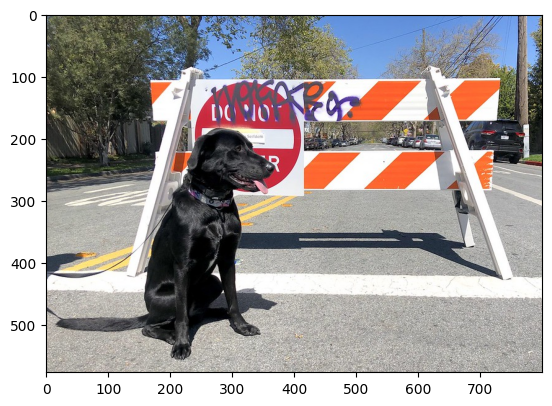

In [4]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data",
)

# The MobileNet model expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=str(image_filename)), code=cv2.COLOR_BGR2RGB)
plt.imshow(image);

### Preprocess image for MobileNet
[back to top ⬆️](#Table-of-contents:)

In [5]:
# Resize to MobileNetV3 input image shape.
preprocessed_image = cv2.resize(src=image, dsize=(224, 224))
# Add batch dimension
preprocessed_image = np.expand_dims(preprocessed_image, 0)

## Basic usage: Auto mode explainer
[back to top ⬆️](#Table-of-contents:)

The easiest way to run the explainer is to do it in Auto mode. Under the hood of Auto mode, it will first try to run the `White-Box` mode. If this fails, it will then run the `Black-Box` mode. See more details about [White-Box](#White-Box-explainer) and [Black-Box](#Black-Box-explainer) modes below.

Generating saliency maps involves model inference. The explainer will perform model inference, but to do so, it requires `preprocess_fn` and `postprocess_fn`.  
At this stage, we can avoid passing `preprocess_fn` by preprocessing the data beforehand (e.g., resizing and adding a batch dimension as shown above). We also don't pass `postprocess_fn` here for simplicity, since the White-Box mode doesn't fail on the example model.

To learn more about pre- and post-process functions, refer to the [Pre- and post-process functions](#Pre--and-post-process-functions) section.

### Create Explainer
[back to top ⬆️](#Table-of-contents:)

In [6]:
# Create ov.Model
model = ov.Core().read_model(model_xml_path)

# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
)

INFO:openvino_xai:Assigning preprocess_fn to identity function assumes that input images were already preprocessed by user before passing it to the model. Please define preprocessing function OR preprocess images beforehand.
INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


### Do explanation
[back to top ⬆️](#Table-of-contents:)

The predicted label for this image is `flat-coated_retriever` with label index `206`. So here and further we will check saliency maps for this index.

In [7]:
# You can choose classes to generate saliency maps for.
# In this notebook we will check maps for predicted class 206 - flat-coated retriever
retriever_class_index = 206

In [8]:
explanation = explainer(
    preprocessed_image,
    targets=retriever_class_index,
    overlay=True,  # False by default
)

### Visualize saliency maps
[back to top ⬆️](#Table-of-contents:)

Saliency maps were generated for the following classes: [206]
Saliency map size: (224, 224, 3)


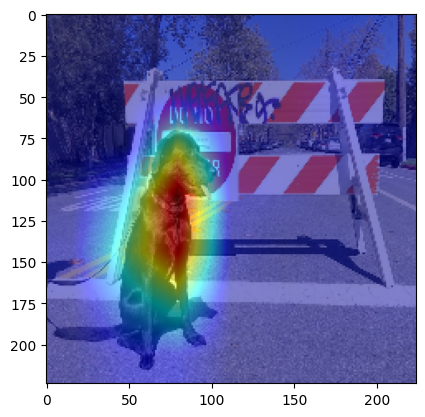

In [9]:
explanation: Explanation
# Dict[int: np.ndarray] where key - class id, value - processed saliency map e.g. 354x500x3
explanation.saliency_map

# Check saved saliency maps
print(f"Saliency maps were generated for the following classes: {explanation.targets}")
print(f"Saliency map size: {explanation.shape}")

# Show saliency maps for retriever class
retriever_sal_map = explanation.saliency_map[retriever_class_index]
plt.imshow(retriever_sal_map);

### Save saliency maps
[back to top ⬆️](#Table-of-contents:)

In [10]:
# Save saliency map
output = base_artifacts_dir / "explain_auto"
explanation.save(output)

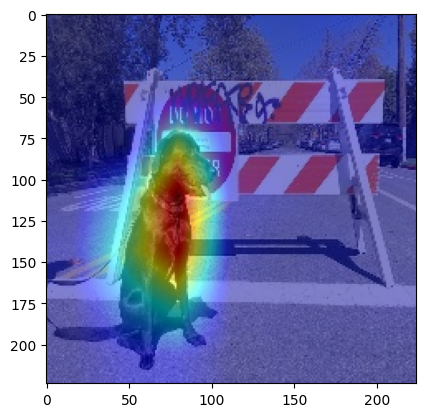

In [11]:
# See saved saliency maps
image_sal_map = cv2.imread(f"{output}/target_{retriever_class_index}.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map);

### Return saliency maps for all classes
[back to top ⬆️](#Table-of-contents:)

In [12]:
explanation = explainer(preprocessed_image, targets=-1)

# Check saved saliency maps
print(f"Saliency maps were generated for the following classes: {explanation.targets}")
print(f"Saliency map size: {explanation.shape}")

Saliency maps were generated for the following classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210

## Pre- and post-process functions
[back to top ⬆️](#Table-of-contents:)

The explainer can apply pre-processing internally during model inference, allowing you to provide a raw image as input to the explainer.

To enable this, define `preprocess_fn` and provide it to the explainer constructor. By default, `preprocess_fn` is an identity function that passes the input without any changes, assuming it is preprocessed beforehand.

In Auto mode, the explainer tries to run the White-Box mode first. If it fails, the corresponding exception will be raised, and the Black-Box mode will be enabled as a fallback.

The Black-Box mode requires access to the output `logits` (activated or not). Therefore, in such cases, `postprocess_fn` is required, which accepts the raw IR model output and returns logits (see below for a reference).


In [13]:
def preprocess_fn(x: np.ndarray) -> np.ndarray:
    # Implementing own pre-process function based on model's implementation
    x = cv2.resize(src=x, dsize=(224, 224))

    # Add batch dimension
    x = np.expand_dims(x, 0)
    return x


def postprocess_fn(x: OVDict):
    # Implementing own post-process function based on model's implementation
    # Return "logits" model output
    return x[0]

In [14]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
)

explanation = explainer(image, targets=retriever_class_index)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).


INFO:openvino_xai:Explaining the model in white-box mode.


## Visualization Parameters
[back to top ⬆️](#Table-of-contents:)

- resize (True by default): If True, resize saliency map to the input image size.
- colormap (True by default): If True, apply colormap to the grayscale saliency map.
- overlay (False by default): If True, generate overlay of the saliency map over the input image.
- original_input_image (None by default): Provide the original, unprocessed image to apply the overlay. This ensures the overlay is not applied to a preprocessed image, which may be resized or normalized and lose readability.
- overlay_weight (0.5 by default): Weight of the saliency map when overlaying the input data with the saliency map.

INFO:openvino_xai:Assigning preprocess_fn to identity function assumes that input images were already preprocessed by user before passing it to the model. Please define preprocessing function OR preprocess images beforehand.
INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


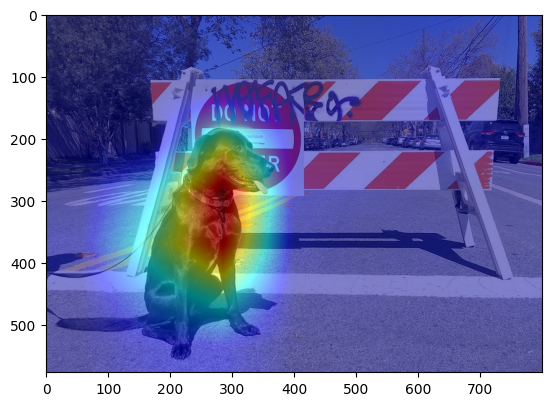

In [15]:
# Create explainer object
explainer = xai.Explainer(model=model, task=xai.Task.CLASSIFICATION)

# Return overlayed image
explanation = explainer(
    preprocessed_image,
    targets=[retriever_class_index],  # target can be a single label index, label name or a list of indices/names
    overlay=True,  # False by default
    original_input_image=image,  # to apply overlay on the original image instead of preprocessed one that was used for the explainer
)

retriever_sal_map = explanation.saliency_map[retriever_class_index]
plt.imshow(retriever_sal_map)

# Save saliency map
output = base_artifacts_dir / "overlay"
explanation.save(output)

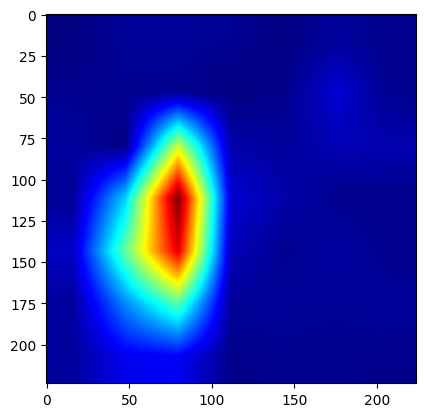

In [16]:
# Return low-resolution saliency map
explanation = explainer(
    preprocessed_image,
    targets=[retriever_class_index],  # target can be a single label index, label name or a list of indices/names
    overlay=False,  # False by default
)

retriever_sal_map = explanation.saliency_map[retriever_class_index]
plt.imshow(retriever_sal_map)

# Save saliency map
output = base_artifacts_dir / "colormap"
explanation.save(output)

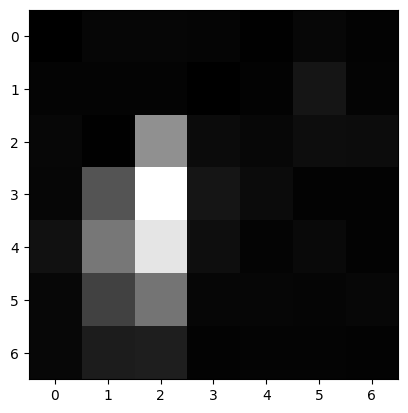

In [17]:
# Return low-resolution gray-scale saliency map
explanation = explainer(
    preprocessed_image,
    targets=[retriever_class_index],  # target can be a single label index, label name or a list of indices/names
    resize=False,  # True by default
    colormap=False,  # True by default
)

retriever_sal_map = explanation.saliency_map[retriever_class_index]
plt.imshow(retriever_sal_map, cmap="gray")

# Save saliency map
output = base_artifacts_dir / "grayscale"
explanation.save(output)

## White-Box explainer
[back to top ⬆️](#Table-of-contents:)


### ReciproCAM explain method
[back to top ⬆️](#Table-of-contents:)


The White-Box explainer treats the model as a white box and needs to make inner modifications. It adds extra XAI nodes after the backbone to estimate which activations are important for model prediction.

If a method is not specified, the XAI branch will be generated using the [ReciproCAM](https://arxiv.org/abs/2209.14074) method.

By default, the insertion of the XAI branch will be done automatically by searching for the correct node.

It works quickly and precisely, requiring only one model inference.

In [18]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    # defaults to ExplainMode.AUTO
    explain_mode=ExplainMode.WHITEBOX,
    # ReciproCAM is the default XAI method for CNNs
    explain_method=xai.Method.RECIPROCAM,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


### Insert XAI branch
[back to top ⬆️](#Table-of-contents:)

It's possible to update the model with an XAI branch using the `insert_xai` functional API.

`insert_xai` will return an OpenVINO model with the XAI branch inserted and an additional `saliency_map` output.

This helps to avoid OpenVINO XAI dependency in the inference environment.

**Note**: XAI branch introduce an additional computational overhead (usually less than a single model forward pass).

In [19]:
# insert XAI branch
model_xai: ov.Model
model_xai = xai.insert_xai(
    model,
    task=xai.Task.CLASSIFICATION,
    explain_method=xai.Method.RECIPROCAM,
    target_layer="MobilenetV3/Conv_1/Conv2D",  # MobileNet V3
    embed_scaling=True,
)

INFO:openvino_xai:Target insertion layer MobilenetV3/Conv_1/Conv2D is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.


### Insertion-related parameters
[back to top ⬆️](#Table-of-contents:)


If automatic search for correct node fails, you can set up a correct node manually with `target_layer` argument. 
For classification it's the last backbone node with shape [1, num_channels, feature_map_height, feature_map_width]. For example, for MobileNetV3 it will be `MobilenetV3/Conv_1/Conv2D` layer with [1, 576, 7, 7] output shape.

To find the right `target_layer` for your model, check the name of the last convolutional layer in the backbone using `.XML` model. 

`embed_scaling` **default True** (for speed purposes), this parameter adds normalization to the XAI branch, which results in being able to visualize saliency maps right away without further postprocessing.

In [20]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.AUTO,
    explain_method=xai.Method.RECIPROCAM,
    # target_layer="last_conv_node_name",  # target_layer - node after which XAI branch will be inserted
    target_layer="MobilenetV3/Conv_1/Conv2D",
    embed_scaling=True,  # True by default.  If set to True, saliency map scale (0 ~ 255) operation is embedded in the model
)

INFO:openvino_xai:Target insertion layer MobilenetV3/Conv_1/Conv2D is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


## Black-Box explainer
[back to top ⬆️](#Table-of-contents:)

The Black-Box method treats the model as a black box without altering its structure. Therefore, this method will work on any model that can be inferred and return class probabilities as output.

The [RISE](https://arxiv.org/pdf/1806.07421.pdf) algorithm used in Black-Box mode applies random masks to hide parts of the image, retrieves the resulting class probabilities, and uses this information to calculate the "importance" of each part of the image for the final results. After performing thousands of inferences, a summarized saliency map is generated.

While it is convenient to treat every model as a black box for explanation purposes, this algorithm may require a large number of inferences (defaulting to 5000) to generate a high-quality saliency map.

In [21]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    postprocess_fn=postprocess_fn,
    explain_mode=ExplainMode.BLACKBOX,  # defaults to AUTO
)

# Generate explanation
explanation = explainer(
    image,
    targets=retriever_class_index,
    # targets=-1,  # Explain all classes
    overlay=True,
    num_masks=1000,  # kwargs of the RISE algo
)

INFO:openvino_xai:Explaining the model in black-box mode.
Explaining in synchronous mode: 100%|██████████| 1000/1000 [00:03<00:00, 259.73it/s]


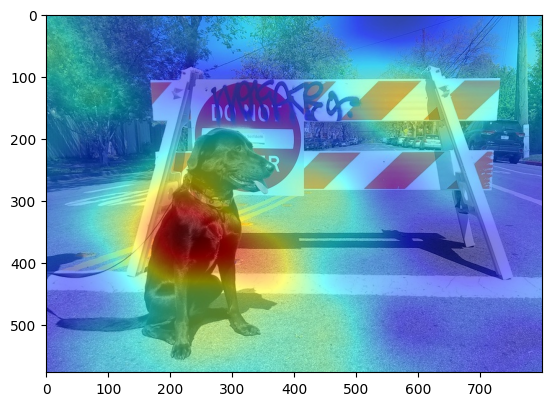

In [22]:
# Save saliency map
output = base_artifacts_dir / "blackbox_explain"
explanation.save(output)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output}/target_{retriever_class_index}.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map);

For the `Black-Box explainer`, the number of masks and cells is crucial for achieving good results. In the example above, it's evident that the number of masks was insufficient to create a high-quality map.

Varying the `num_cells` and `num_masks` parameters can achieve different goals:
- To speed up the explanation, you can reduce the number of `num_masks`. However, this will decrease the quality of the resulting saliency maps, making it suitable for large and focused objects.
- Increasing `num_cells` provides a more fine-grained result, but it requires a larger `num_masks` to converge. This approach is more effective for classes with complex shapes.

## Advanced
[back to top ⬆️](#Table-of-contents:)

### Import ImageNet label names and add them to saliency maps
[back to top ⬆️](#Table-of-contents:)

If `label_names` are not provided to the explainer call, the saved saliency map will have the predicted class index, not the name. For example, `image_name_target_206.jpg` instead of `image_name_target_retriever.jpg`.

To conveniently view label names in saliency maps, we provide ImageNet label names information to the explanation call.

In [23]:
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory="data",
)

imagenet_classes = imagenet_filename.read_text().splitlines()

'data/imagenet_2012.txt' already exists.


In [24]:
imagenet_labels = []
for label in imagenet_classes:
    class_label = " ".join(label.split(" ")[1:])
    first_class_label = class_label.split(",")[0].replace(" ", "_")
    imagenet_labels.append(first_class_label)

print(" ".join(imagenet_labels[:10]))

tench goldfish great_white_shark tiger_shark hammerhead electric_ray stingray cock hen ostrich


In [25]:
# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_labels = ["background"] + imagenet_labels

In [26]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
)

# Adding ImageNet label names.
explanation = explainer(
    image,
    # Return saliency maps for 2 named labels
    targets=["flat-coated_retriever", "microwave"],  # Also label indices [206, 652] are possible as target
    label_names=imagenet_labels,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


In [27]:
# Save saliency map
output = base_artifacts_dir / "label_names"
explanation.save(output)

Below in `base_artifacts_dir / "label_names"` you can see saved saliency maps with label name on it:

In [28]:
# See saliency mas saved in `output` with predicted label in image name
for file_name in output.glob("*"):
    print(file_name)

artifacts/label_names/target_microwave.jpg
artifacts/label_names/target_flat-coated_retriever.jpg


### Activation map explain method
[back to top ⬆️](#Table-of-contents:)

The Activation Map method shows a general attention map without respect to specific classes. It can be useful for understanding which areas the model identifies as important.

If the explanation method is set to `Method.ACTIVATIONMAP`, instead of saliency maps for each class, the activation map is returned as `explanation.saliency_map["per_image_map"]`.

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ActivationMap method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


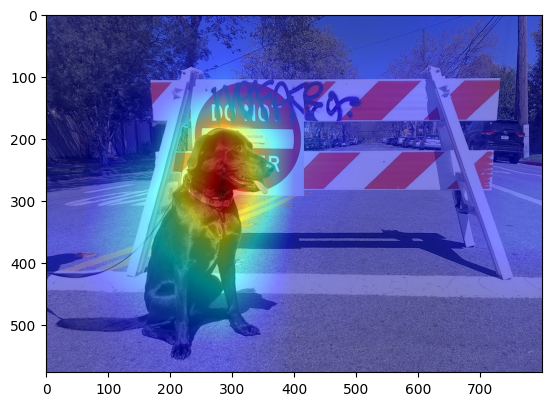

In [29]:
# Create explainer object
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
    preprocess_fn=preprocess_fn,
    explain_mode=ExplainMode.WHITEBOX,
    explain_method=xai.Method.ACTIVATIONMAP,
)

explanation = explainer(image, targets=-1, overlay=True)
activation_map = explanation.saliency_map["per_image_map"]

plt.imshow(activation_map)
plt.show()